In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install split-folders --quiet
!pip install torch torchvision transformers datasets --quiet
!pip install roboflow --quiet
!pip install ultralytics --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but 

In [ ]:
!nvidia-smi

Tue Jul 23 11:13:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="f92r8UAteQo539m5sPi1")
project = rf.workspace("esd-krexe").project("drowsiness-detection-0mcjg")
version = project.version(1)
dataset = version.download("folder")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Drowsiness-detection-1 in folder:: 100%|██████████| 9131/9131 [00:03<00:00, 2713.45it/s]


In [ ]:
from transformers import ViTImageProcessor
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor)

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            # ToTensor(),
            normalize,
        ]
    )

def train_transforms(image):
    return _train_transforms(image.convert("RGB"))

def val_transform(image):
    return _val_transforms(image)



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
from transformers import ViTModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch.nn.functional as F

class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=3):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)

        loss = None
        if labels is not None:
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        if loss is not None:
          return logits, loss.item()
        else:
          return logits, None

In [ ]:
import torchvision
from torchvision.transforms import ToTensor

train_ds = torchvision.datasets.ImageFolder('/content/Drowsiness-detection-1/train/', transform=ToTensor())
valid_ds = torchvision.datasets.ImageFolder('/content/Drowsiness-detection-1/valid/', transform=ToTensor())
test_ds = torchvision.datasets.ImageFolder('/content/Drowsiness-detection-1/test/', transform=ToTensor())

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch
from ultralytics import YOLO
from PIL import Image
import numpy as np

# Load ViT model
vit_model = ViTForImageClassification(2)
vit_model.load_state_dict(torch.load('/content/drive/My Drive/ViT - patience - 5.pt', map_location=device))
vit_model.eval()

# Load YOLO model
yolo_model = YOLO("/content/drive/MyDrive/YOLOv8 - 20 - Epochs.pt")

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
import torch.nn as nn

class MetaModel(nn.Module):
    def __init__(self, vit_model, yolo_model, num_classes):
        super(MetaModel, self).__init__()
        self.vit = vit_model
        self.yolo = yolo_model.model
        self.fc = nn.Linear(4, num_classes)

    def forward(self, pixel_values, labels):
        vit_input = val_transform(pixel_values)
        vit_logits, _ = self.vit(pixel_values=vit_input, labels=labels)

        yolo_logits = self.yolo(pixel_values)

        combined_features = torch.cat((vit_logits, yolo_logits), dim=1)
        logits = self.fc(combined_features)
        return logits

In [ ]:
import torch.utils.data as data
train_dataloader = data.DataLoader(train_ds, batch_size=16, shuffle=True)
valid_dataloader = data.DataLoader(valid_ds, batch_size=16, shuffle=True)
test_dataloader = data.DataLoader(test_ds, batch_size=16, shuffle=True)

In [ ]:
# x, y = next(iter(train_dataloader))
# x = x.to(device)
# y = y.to(device)
# meta_model = MetaModel(vit_model, yolo_model, 2)
# meta_model.to(device)
# results = meta_model(x, y)

In [ ]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm
import copy

meta_model = MetaModel(vit_model, yolo_model, 2)
meta_model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(meta_model.parameters(), lr=3e-5)
num_epochs = 10

patience = 3
best_val_loss = float('inf')
patience_counter = 0
best_model_weights = copy.deepcopy(meta_model.state_dict())

for epoch in range(num_epochs):
    meta_model.train()
    train_loss = 0.0
    train_correct = 0
    total = 0

    # Training
    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = batch
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = meta_model(inputs, labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = train_correct / total
    train_loss /= len(train_dataloader)

    # Validation
    meta_model.eval()
    valid_loss = 0.0
    valid_correct = 0
    total = 0
    with torch.no_grad():
        for batch in tqdm(valid_dataloader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = batch
            inputs, labels = inputs.cuda(), labels.cuda()

            outputs = meta_model(inputs, labels)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

    valid_accuracy = valid_correct / total
    valid_loss /= len(valid_dataloader)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

    # Early stopping and saving the best model
    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        best_model_weights = copy.deepcopy(meta_model.state_dict())
        patience_counter = 0  # Reset the counter if we get a better result
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

# Load the best model weights
meta_model.load_state_dict(best_model_weights)
torch.save(meta_model.state_dict(), 'best.pt')

print("Training complete.")

Validation Epoch 1/10: 100%|██████████| 114/114 [00:59<00:00,  1.91it/s]


Epoch 1/10
Train Loss: 0.3285, Train Accuracy: 0.9204
Valid Loss: 0.1951, Valid Accuracy: 0.9441


Validation Epoch 2/10: 100%|██████████| 114/114 [00:59<00:00,  1.93it/s]


Epoch 2/10
Train Loss: 0.1337, Train Accuracy: 0.9798
Valid Loss: 0.1527, Valid Accuracy: 0.9534


Validation Epoch 3/10: 100%|██████████| 114/114 [00:59<00:00,  1.93it/s]


Epoch 3/10
Train Loss: 0.0889, Train Accuracy: 0.9814
Valid Loss: 0.1372, Valid Accuracy: 0.9611


Validation Epoch 4/10: 100%|██████████| 114/114 [00:58<00:00,  1.95it/s]


Epoch 4/10
Train Loss: 0.0631, Train Accuracy: 0.9862
Valid Loss: 0.1447, Valid Accuracy: 0.9545


Validation Epoch 5/10: 100%|██████████| 114/114 [00:59<00:00,  1.93it/s]


Epoch 5/10
Train Loss: 0.0482, Train Accuracy: 0.9897
Valid Loss: 0.1678, Valid Accuracy: 0.9501


Validation Epoch 6/10: 100%|██████████| 114/114 [00:58<00:00,  1.96it/s]


Epoch 6/10
Train Loss: 0.0384, Train Accuracy: 0.9906
Valid Loss: 0.1832, Valid Accuracy: 0.9545
Early stopping triggered.
Training complete.


Testing: 100%|██████████| 57/57 [00:29<00:00,  1.94it/s]


              precision    recall  f1-score   support

           0       0.94      0.94      0.94       478
           1       0.93      0.94      0.94       434

    accuracy                           0.94       912
   macro avg       0.94      0.94      0.94       912
weighted avg       0.94      0.94      0.94       912

Test Loss: 0.1843 | Test Accuracy: 0.94 | F1 Score: 0.94


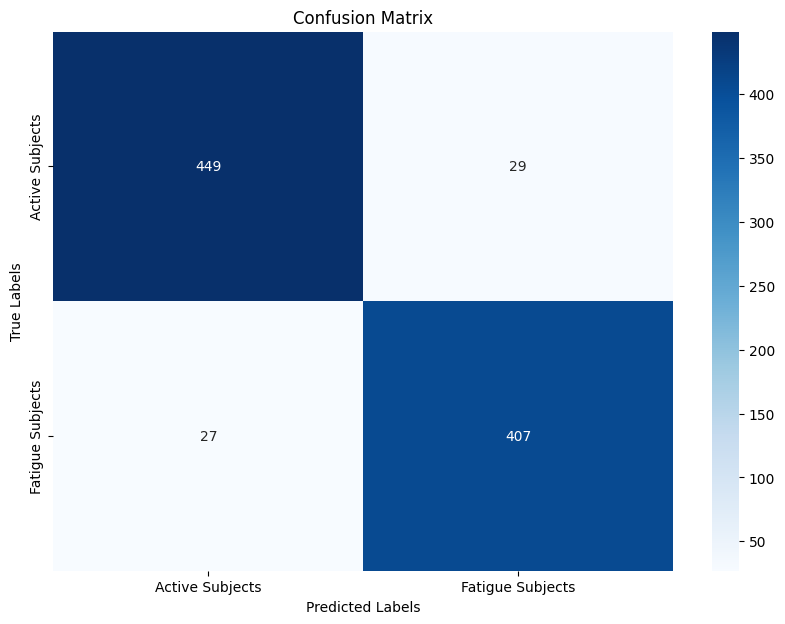

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
meta_model.load_state_dict(torch.load('best.pt'))
meta_model.to(device)
meta_model.eval()
test_loss = 0.0
test_correct = 0
total = 0
all_predictions = []
all_labels = []
with torch.no_grad():
  for batch in tqdm(test_dataloader, desc=f"Testing"):
    inputs, labels = batch
    inputs, labels = inputs.cuda(), labels.cuda()

    optimizer.zero_grad()
    outputs = meta_model(inputs, labels)
    loss = criterion(outputs, labels)

    test_loss += loss.item()
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    test_correct += (predicted == labels).sum().item()

    all_predictions.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

test_accuracy = test_correct / total
test_loss /= len(test_dataloader)
f1 = f1_score(all_labels, all_predictions, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_predictions)
print(classification_report(all_labels, all_predictions))
print(f'Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.2f} | F1 Score: {f1:.2f}')

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_ds.classes, yticklabels=test_ds.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from google.colab import files
files.download('best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>